In [1]:
from IPython.core.interactiveshell import InteractiveShell
import time

old_run_cell = InteractiveShell.run_cell

def timing_run_cell(self, raw_cell, *args, **kwargs):
    t0 = time.time()
    result = old_run_cell(self, raw_cell, *args, **kwargs)
    t1 = time.time()
    print(f"Execution time: {t1 - t0:.1f} seconds")
    return result

InteractiveShell.run_cell = timing_run_cell

In [2]:
!pip install zoobot
!pip install pyro-ppl
!pip install pytorch_lightning
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Execution time: 17.7 seconds


In [3]:
import sys
sys.path.append('../Scripts')

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from zoobot.pytorch.training import finetune
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier, LinearHead
from torchvision.models import efficientnet_b0

from auxiliary_functions import (aggressive_arcsinh_scaling, ClassificationDataset_values, 
                        train_epoch, evaluate, compute_metrics, evaluate_with_probabilities, plot_confusion_matrix)
from DataCore import ClassificationDataset_labels,ClassificationArrayDataset


Execution time: 7.3 seconds


In [4]:
unityTransform = lambda x: x

# Load labels and data
label_file = "/net/virgo01/data/users/spirov/Deep/catalog_tng100_jwst_all_50sns.fits"
labels = fits.open(label_file)[1]  # second HDU

datadir = "/net/virgo01/data/users/mahesh/DeepLearning/data/"

# Create the dataset using the scaling
dataset = ClassificationArrayDataset(datadir, labels, unityTransform)

# # dataset splits
# total_samples = len(dataset)
# indices = list(range(total_samples))
# train_split = int(0.81 * total_samples)
# val_split = int(0.9 * total_samples)
# train_indices = indices[:train_split]
# val_indices = indices[train_split:val_split]
# test_indices = indices[val_split:]

# train_dataset = Subset(dataset, train_indices)
# val_dataset = Subset(dataset, val_indices)
# test_dataset = Subset(dataset, test_indices)

# dataset splits - you gotta stratify to make sure that all the datasets have galaxies with all labels, otherwise you end up with no pre/post mergers in val or test splits
y = []
for i in range(len(dataset)):
    _, label = dataset[i]
    y.append(label.item())
y = np.array(y)

# First split: 90% train+val, 10% test
trainval_indices, test_indices = train_test_split(
    np.arange(len(y)),
    test_size=0.1,
    stratify=y,
    random_state=42
)

# Second split: of the 90%, 90% train, 10% val (so total 81/9/10)
y_trainval = y[trainval_indices]
train_indices, val_indices = train_test_split(
    trainval_indices,
    test_size=0.1, 
    stratify=y_trainval,
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

train_counts = [0, 0, 0]
for i in train_indices:
    row = labels.data[i]
    if row['is_pre_merger'] == 1: 
        train_counts[1] += 1
    elif row['is_ongoing_merger'] == 1 or row['is_post_merger'] == 1: 
        train_counts[2] += 1
    else: 
        train_counts[0] += 1
weights = 1.0 / np.array(train_counts)
weights /= weights.sum()
weights_t = torch.tensor(weights, dtype=torch.float)

# Model Setup with Zoobot (One-Stage Classification)
# load the Zoobot pre-trained EfficientNet-B0 model
model = FinetuneableZoobotClassifier(
    name='hf_hub:mwalmsley/zoobot-encoder-efficientnet_b0',
    n_blocks=2,              # number of layers to train - max 7 for efficientnet_b0, set 0 for only head
    learning_rate=1e-5,      # Use their learning rate
    lr_decay=0.5,
    num_classes=3            # Three classes: non-merger, pre-merger, post-merger
)
# uncomment below to use torchvision's EfficientNet-B0 (note: this model is pre-trained on ImageNet, not on Galaxy Zoo labels)
#model = efficientnet_b0(pretrained=True)

# Modify the classifier head to output three classes
if hasattr(model, 'head'):
    in_features = model.head.linear.in_features
    # Update the dropout probability (optional
    model.head.dropout.p = 0.2
    
    model.head.linear = nn.Linear(in_features, 3)
else:
    raise ValueError("Model structure not recognized. Please adjust or face my wrath.")

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Execution time: 456.3 seconds


In [5]:
#model

Execution time: 0.0 seconds


In [6]:
with fits.open(label_file) as hdul:
    data = hdul[1].data  # The second HDU

n_total = len(data)

# Count how many are flagged as each type
n_pre = len(data[data['is_pre_merger'] == 1])
n_ongoing = len(data[data['is_ongoing_merger'] == 1])
n_post = len(data[data['is_post_merger'] == 1])

# A simple definition of 'non-merger' is galaxies that have none of the three flags
n_non = n_total - (n_pre + n_ongoing + n_post)

print(f"Total galaxies: {n_total}")
print(f"Pre-merger: {n_pre} ({n_pre / n_total * 100:.2f}%)")
print(f"Ongoing merger: {n_ongoing} ({n_ongoing / n_total * 100:.2f}%)")
print(f"Post-merger: {n_post} ({n_post / n_total * 100:.2f}%)")
print(f"Non-merger: {n_non} ({n_non / n_total * 100:.2f}%)")

Total galaxies: 58436
Pre-merger: 1267 (2.17%)
Ongoing merger: 511 (0.87%)
Post-merger: 636 (1.09%)
Non-merger: 56022 (95.87%)
Execution time: 0.2 seconds


Total galaxies: 58436

Pre-merger: 1267 (2.17%)

Ongoing merger: 511 (0.87%)

Post-merger: 636 (1.09%)

Non-merger: 56022 (95.87%)

In [7]:
checking = []
for i in test_indices:
    row = labels.data[i]
    if row['is_pre_merger'] == 1:
        checking.append(1)
    elif row['is_ongoing_merger'] == 1 or row['is_post_merger'] == 1:
        checking.append(2)
    else:
        checking.append(0)

unique, counts = np.unique(checking, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5606, 1: 127, 2: 111}
Execution time: 0.2 seconds


In [8]:
# Hyperparameters (following the paper's one-stage configuration)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.005)
criterion = nn.CrossEntropyLoss(weight=weights_t.to(device))

# training and validation Loop

num_epochs = 5
best_val_loss = np.inf
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    last_print_time = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, val_loader, criterion, device)
    current_time = time.time()
    elapsed = current_time - last_print_time
    print(f"\n[{elapsed:.1f}s elapsed] Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss = {train_loss:.3f}, Train Acc = {train_acc:.3f}; "
          f"Val Loss = {val_loss:.3f}, Val Acc = {val_acc:.3f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")


[207.1s elapsed] Epoch 1/5: Train Loss = 1.095, Train Acc = 0.557; Val Loss = 1.092, Val Acc = 0.754

[205.2s elapsed] Epoch 2/5: Train Loss = 1.089, Train Acc = 0.743; Val Loss = 1.086, Val Acc = 0.753

[205.4s elapsed] Epoch 3/5: Train Loss = 1.084, Train Acc = 0.737; Val Loss = 1.081, Val Acc = 0.753

[213.6s elapsed] Epoch 4/5: Train Loss = 1.078, Train Acc = 0.748; Val Loss = 1.075, Val Acc = 0.747

[203.1s elapsed] Epoch 5/5: Train Loss = 1.072, Train Acc = 0.738; Val Loss = 1.070, Val Acc = 0.736
Execution time: 1034.8 seconds



Test Loss: 1.067
Test Accuracy: 0.726


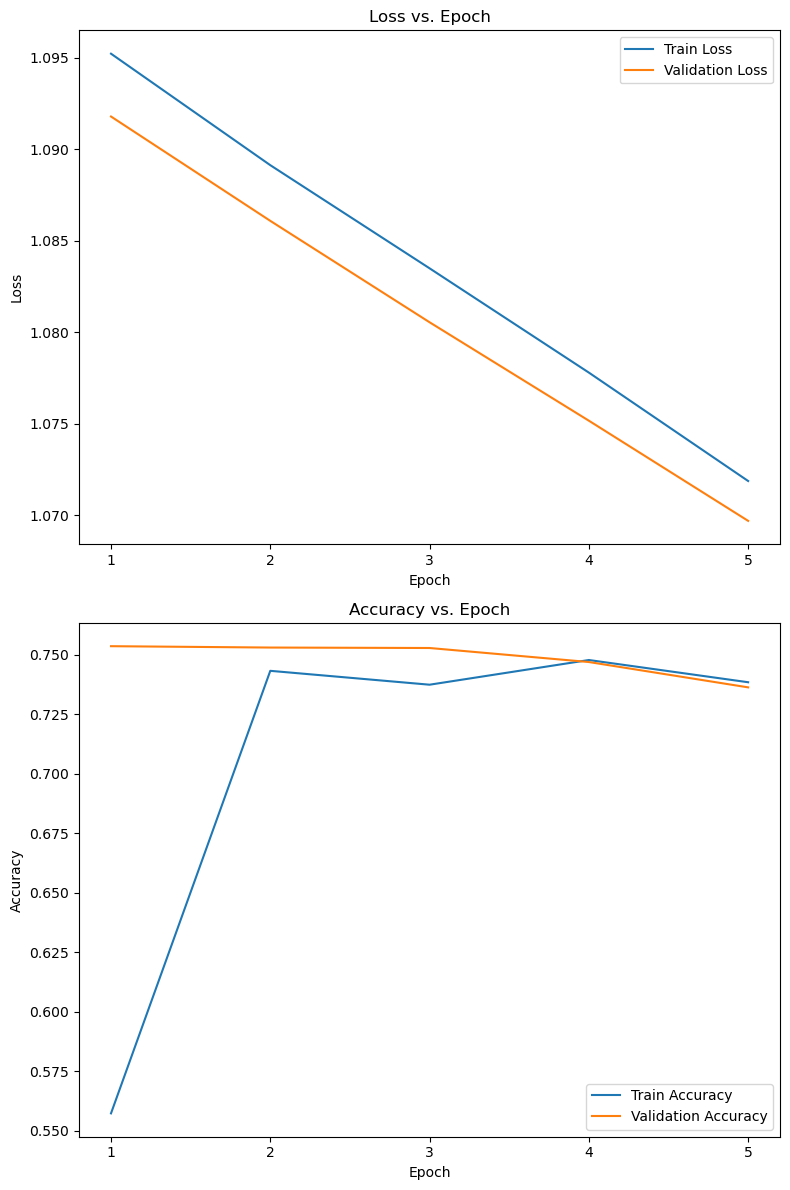

Confusion Matrix:
 [[4163 1185  258]
 [  52   73    2]
 [  69   34    8]]


/tmp/ipykernel_2433392/1584178221.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<Figure size 600x500 with 0 Axes>

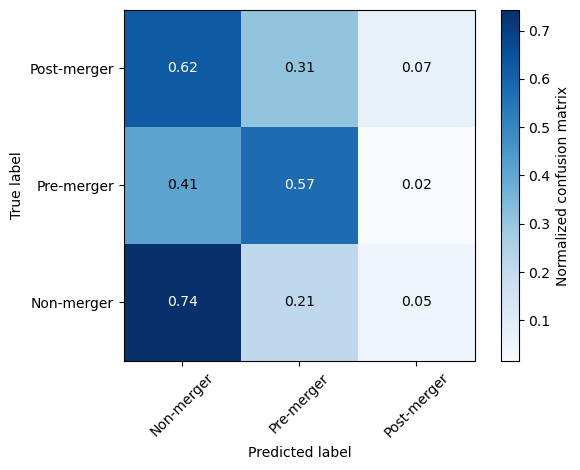

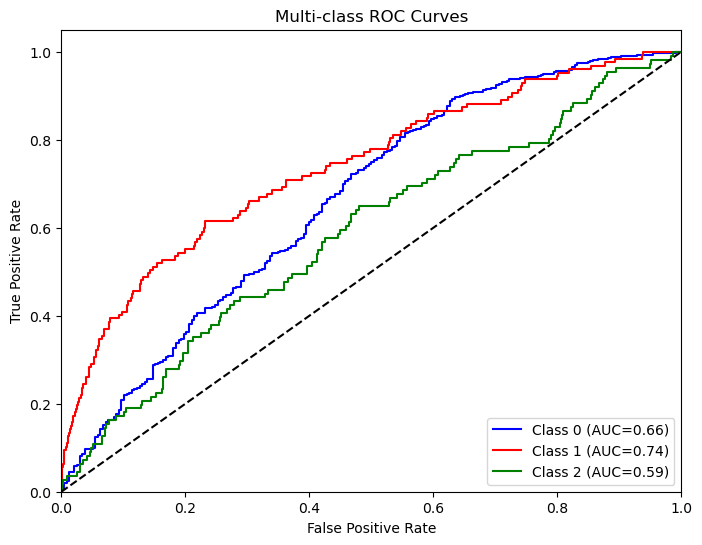

Execution time: 50.0 seconds


In [9]:
# Evaluation on Test Set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

ax1.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
ax1.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
ax1.set_xticks(range(1, num_epochs+1))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss vs. Epoch")
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
ax2.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
ax2.set_xticks(range(1, num_epochs+1))
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy vs. Epoch")
ax2.legend()

plt.tight_layout()
plt.show()

#confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:\n", cm)

test_labels_arr, test_preds_arr = np.array(test_labels), np.array(test_preds)

plt.figure(figsize=(6,5))
plot_confusion_matrix(
    y_true=test_labels_arr,
    y_pred=test_preds_arr,
    classes=['Non-merger', 'Pre-merger', 'Post-merger'],
    normalize=True
)

# Compute probabilities on the test set
model.load_state_dict(torch.load("best_model.pth"))
test_probs, test_labels = evaluate_with_probabilities(model, test_loader, device)
test_preds = np.argmax(test_probs, axis=1)

# ROC Curves for Multi-class (One-vs-Rest)
n_classes = 3
# Binarize the true labels
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2])
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:,i], test_probs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8,6))
colors = ['blue','red','green']
for i,c in zip(range(n_classes),colors):
    plt.plot(fpr[i], tpr[i], color=c, label=f'Class {i} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [10]:
unique, counts = np.unique(test_preds_arr, return_counts=True)
print(dict(zip(unique, counts)))

{0: 4284, 1: 1292, 2: 268}
Execution time: 0.0 seconds
